In [1]:
%matplotlib notebook

from amsre_averaged_v7 import AMSREaveraged
from quikscat_daily_v4 import QuikScatDaily

import numpy as np
import sys
import netCDF4 as nc4

import matplotlib.pyplot as plt
from pycurrents.data.timetools import ddtime, day_to_dt64, dt64_to_ymdhms

## Read in Data

In [2]:
def read_dataq(filename):
    dataset = QuikScatDaily(filename, missing=-999)
    if not dataset.variables: sys.exit('file not found')
    return dataset
dsq = read_dataq('qscat_20060520v4.gz')

In [3]:
def read_dataa(filename):
    dataset = AMSREaveraged(filename, missing=-999)
    if not dataset.variables: sys.exit('file not found')
    return dataset
dsa = read_dataa('f32_20060520v7_d3d.gz')

In [26]:
#asmr
#(lat,lon)
sst = dsa.variables['sst']
lonA = dsa.variables['longitude']
latA = dsa.variables['latitude']
landA = dsa.variables['land']
iceA = dsa.variables['ice']
nodataA = dsa.variables['nodata']

In [27]:
#qscat, choose ascending this time
iasc = 0
idsc = 1

#(lat,lon) (720,1440)
wspdA = dsq.variables['windspd'][iasc,:,:]
wspdD = dsq.variables['windspd'][idsc,:,:]
lonQ = dsq.variables['longitude']
latQ = dsq.variables['latitude']
scatflagA = dsq.variables['scatflag'][iasc,:,:]
scatflagQ = dsq.variables['scatflag'][idsc,:,:]
landQA = dsq.variables['land'][iasc,:,:]
landQD = dsq.variables['land'][idsc,:,:]
iceQA = dsq.variables['ice'][iasc,:,:]
iceQD = dsq.variables['ice'][idsc,:,:]
nodataQA = dsq.variables['nodata'][iasc,:,:]
nodataQD = dsq.variables['nodata'][idsc,:,:]

In [28]:
sst[np.where(sst == -999)] = None
wspdA[np.where(wspdA == -999)] = None
wspdD[np.where(wspdD == -999)] = None

## Functions

In [7]:
def are_equal(array1,array2):
    comparison = array1 == array2
    equal_arrays = comparison.all()
    return equal_arrays

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#, array[idx]

def data_point(lat,lon,data):
    idx_lat = find_nearest(latQ,lat)
    idx_lon = find_nearest(lonQ,lon)
    data_pt = data[idx_lat,idx_lon]
    
    #if np.isnan(data_pt == True):
    #    print("No data here")
    
    return data_pt


def data_slice(latpt,lonpt,data,lat=latA,lon=lonA):

    indi = find_nearest(latA, latpt[0])
    indf = find_nearest(latA, latpt[1])
    sl = np.arange(indi, indf)
    latsl = latA[sl]

    indi2 = find_nearest(lonA,lonpt[0])
    indf2 = find_nearest(lonA, lonpt[1])
    sl = np.arange(indi2, indf2)
    lonsl = lonA[sl]
    
    if data.ndim == 2:
        datasl = data[indi:indf, indi2:indf2]
    elif data.ndim == 3:
        datasl = data[:,indi:indf, indi2:indf2]
    
    return latsl, lonsl, datasl


In [8]:
def clean_data(data1,data2):
    """
    Description: finds the locations of NaN within two data sets and 
    then deletes the Nan in its origin array and the other data array. 
    
    Paramaters: takes two arrays of data that are the same length
    
    Returns: the two given parameters with NaN data removed
    """
    
    bad_ind = np.where((np.isnan(data1) == True) | (np.isnan(data2) == True))
    clean_data1 = np.delete(data1,bad_ind)
    clean_data2 = np.delete(data2,bad_ind)
    
    return clean_data1, clean_data2

In [9]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5, cmap=custom_div_cmap(mincol='#1b7837', maxcol='#762a83'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('Blues'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu_r'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('seismic'),vmin=-40, vmax=40)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='0.4', linewidths=1)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='white', linewidths=1)

In [10]:
#METHOD 1
def smooth_nonan(data,N=17):
    '''
    Description:
    Paramaters: 
    
    '''
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize
    W = data.shape[0]
    L = data.shape[1]
    datasum = np.zeros((W-N+1,L-N+1)) #row, column
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(data.shape[0])
    indx_col = np.arange(data.shape[1])
    
    for i in range(N):
    
        delrow = np.delete(indx_row,slice(ai,W-af))
        data_delrow = np.delete(data,delrow,0)
    
        for j in range(N):       
        
            delcol = np.delete(indx_col,slice(bi,L-bf))
            data_delrowcol = np.delete(data_delrow,delcol,1)  
            
            datasum = np.add(datasum,data_delrowcol)
            #datasum = datasum + data_delrowcol
            
            bi = bi-1
            bf = bf+1

        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    datasmooth = datasum/(N**2)                

    return datasmooth
    
    
smoothnonan = smooth_nonan(sst)

In [11]:
#METHOD 2
def smooth(data, data2, N=17):
    '''
    Description:
    
    Paramaters: "data" will be smoothed, "data2" will NOT be smoothed but 
        it will be shortened to the same size as "data." "N" is the width
        and length of the squares over which "data" is smoothed
    '''
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize    
    W = data.shape[0]
    L = data.shape[1]
    datasum = np.zeros((W-N+1,L-N+1)) #row, column
    counts = np.zeros((W-N+1,L-N+1))    
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(data.shape[0])
    indx_col = np.arange(data.shape[1])
    
    
    for i in range(N):
    
        delrow = np.delete(indx_row,slice(ai,W-af))
        data_delrow = np.delete(data,delrow,0)
    
        for j in range(N):       
            
            #delete excess rows and columns
            delcol = np.delete(indx_col,slice(bi,L-bf))
            data_delrowcol = np.delete(data_delrow,delcol,1)   
            
            #count number of good values
            goodind = np.where(np.isnan(data_delrowcol) == False)
            counts[goodind] = counts[goodind] + 1
            
            #change NaN to zero then add
            data_delrowcol[np.isnan(data_delrowcol) == True] = 0
            datasum = datasum + data_delrowcol     

            bi = bi-1
            bf = bf+1
        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    datasmooth = datasum/counts
    datasmooth[np.where(counts < (N**2)/2)] = None
    
    #delete points that were NaN in original data    
    a = int((N-1)/2)
    datashort = data[a:W-a, a:L-a]
    datasmooth[np.where(np.isnan(datashort) == True)] = None
    
    #makes data2 the same size as data
    data2short = data2[a:W-a, a:L-a]    
    

    
    return datasmooth, data2short


In [12]:
def calculate_QL(SST,U):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    qa = 0.7*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL  #W/m^2


In [13]:
def taylor_expQL(SST,U,N=17,D=0.1):
    '''
    SST = sea surface temperature of your choice (must be same size as U)
    U = Wind velocity of your choice (must be same size as SST)
    N = smoothing
    D = delta
    
    '''
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ushort = smooth(SST,U,N)
        Usm, SSTshort = smooth(U,SST,N)
        
    elif SST.ndim == 3 and U.ndim == 3:
        
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ushort = np.empty(size)
        SSTshort = np.empty(size)
        Usm = np.empty(size)        
        
        for i in range(T):
            SSTsm[i,:,:], Ushort[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTshort[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N)         
        
    else:
        print("Number of Dimensions is Unequal.")
  
    Ti = SSTshort - SSTsm
    Ui = Ushort - Usm       
     
    #get latent heat 
    Q = calculate_QL(SSTshort,Ushort)    

    #First Taylor Expansion term: Q(T_sm,U_sm)
    Q1 = calculate_QL(SSTsm,Usm)
    
    #Second Taylor Expansion term: NOT NUMERICALLY
    Q_DT = (calculate_QL(SSTsm+D,Usm) - calculate_QL(SSTsm-D,Usm))/(2*D)
    Q2 = Q_DT*Ti
    
    #Third Taylor Expansion term: 
    #Q_DU = Q/Ushort
    Q_DU = (calculate_QL(SSTsm,Usm+D) - calculate_QL(SSTsm,Usm-D))/(2*D)
    Q3 = Q_DU*Ui
    
    #Fourth Taylor Expansion term: {Q_tt(T_sm,U_sm) * (T')^2} / 2!
    Q_DTT = (calculate_QL(SSTsm+D,Usm) - 2*Q1 + calculate_QL(SSTsm-D,Usm)) / (D**2)
    Q4 = (Q_DTT * (Ti)**2) / 2
    
    #Fifth Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')^2
    Q_DTDU = (calculate_QL(SSTsm+D,Usm+D)-calculate_QL(SSTsm+D,Usm-D) - \
        calculate_QL(SSTsm-D,Usm+D)+calculate_QL(SSTsm-D,Usm-D))/(4*D*D)
    Q5 = Q_DTDU * Ti * Ui

    #Sixth Taylor Expansion term: Q_uu(T_sm,Usm)*(U')^2} / 2!
    Q_DUU = 0
    
    return Q, Q1, Q2, Q3, Q4, Q5     
    

## Test Smoothing w/ Fake Data

<IPython.core.display.Javascript object>


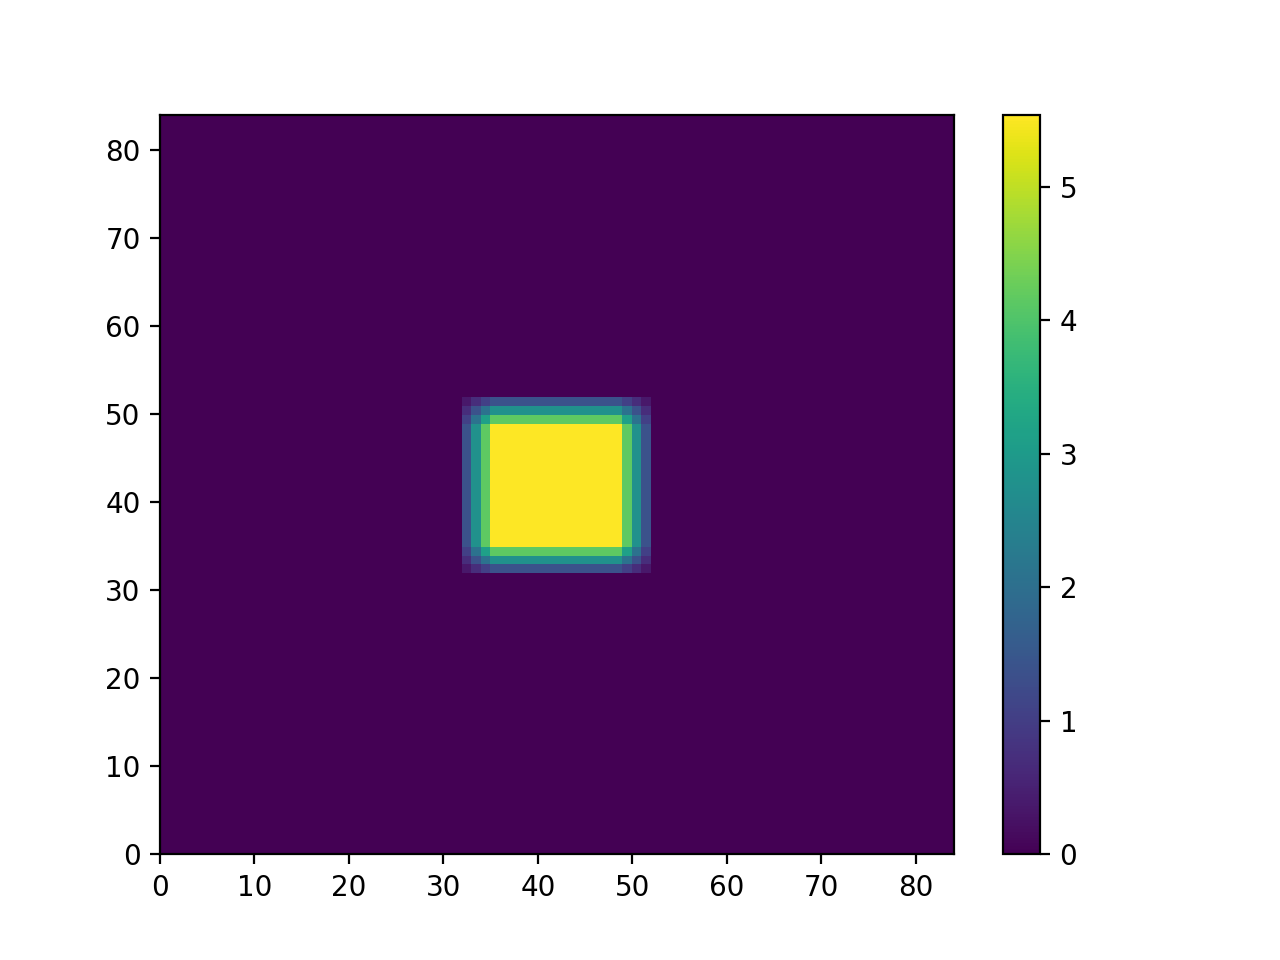

In [14]:
#test smooth function

#create imaginary data; size 100 x 100 w/ values of 100 on top half and 0 on bottom half
fakedata1 = np.zeros((100,100))
fakedata2 = np.zeros((100,100))
fakedata3 = np.zeros((100,100))
fakedata1[50:100,:] = 100
fakedata2[:,50:100] = 100
fakedata3[48:52,48:52] = 100
fakesmooth1,_ = smooth(fakedata1,fakedata1)
fakesmooth2,_ = smooth(fakedata2,fakedata2)
fakesmooth3,_ = smooth(fakedata3,fakedata3)

fig, ax = plt.subplots()
pc = ax.pcolormesh(fakesmooth3)
fig.colorbar(pc,ax=ax)


## Smoothing across Globe

In [29]:
sstsmooth, wspdAshort = smooth(sst,wspdA,N=17)
wspdAsmooth, sstshort = smooth(wspdA,sst,N=17)

a = int((len(latA) - sstsmooth.shape[0])/2)
latAsmooth = latA[a:len(latA)-a]
lonAsmooth = lonA[a:len(lonA)-a]

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print(landA)

<IPython.core.display.Javascript object>


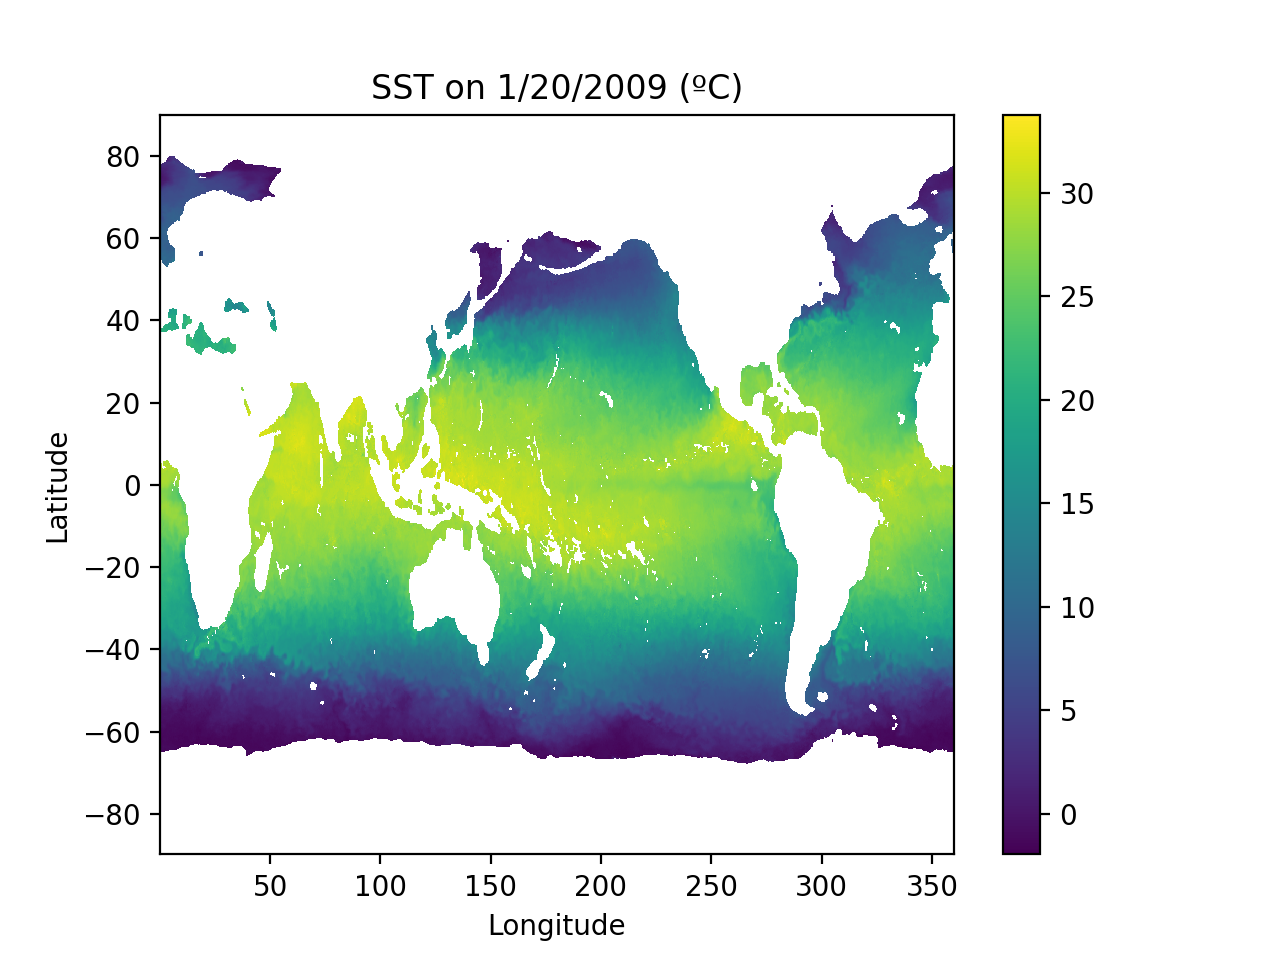

Text(0, 0.5, 'Latitude')

In [30]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonA,latA,sst)
#land_black = np.e
#pc = ax.pcolormesh(lonA,latA,landA)

fig.colorbar(pc,ax=ax)
ax.set_title('SST on 1/20/2009 (ºC)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

<IPython.core.display.Javascript object>


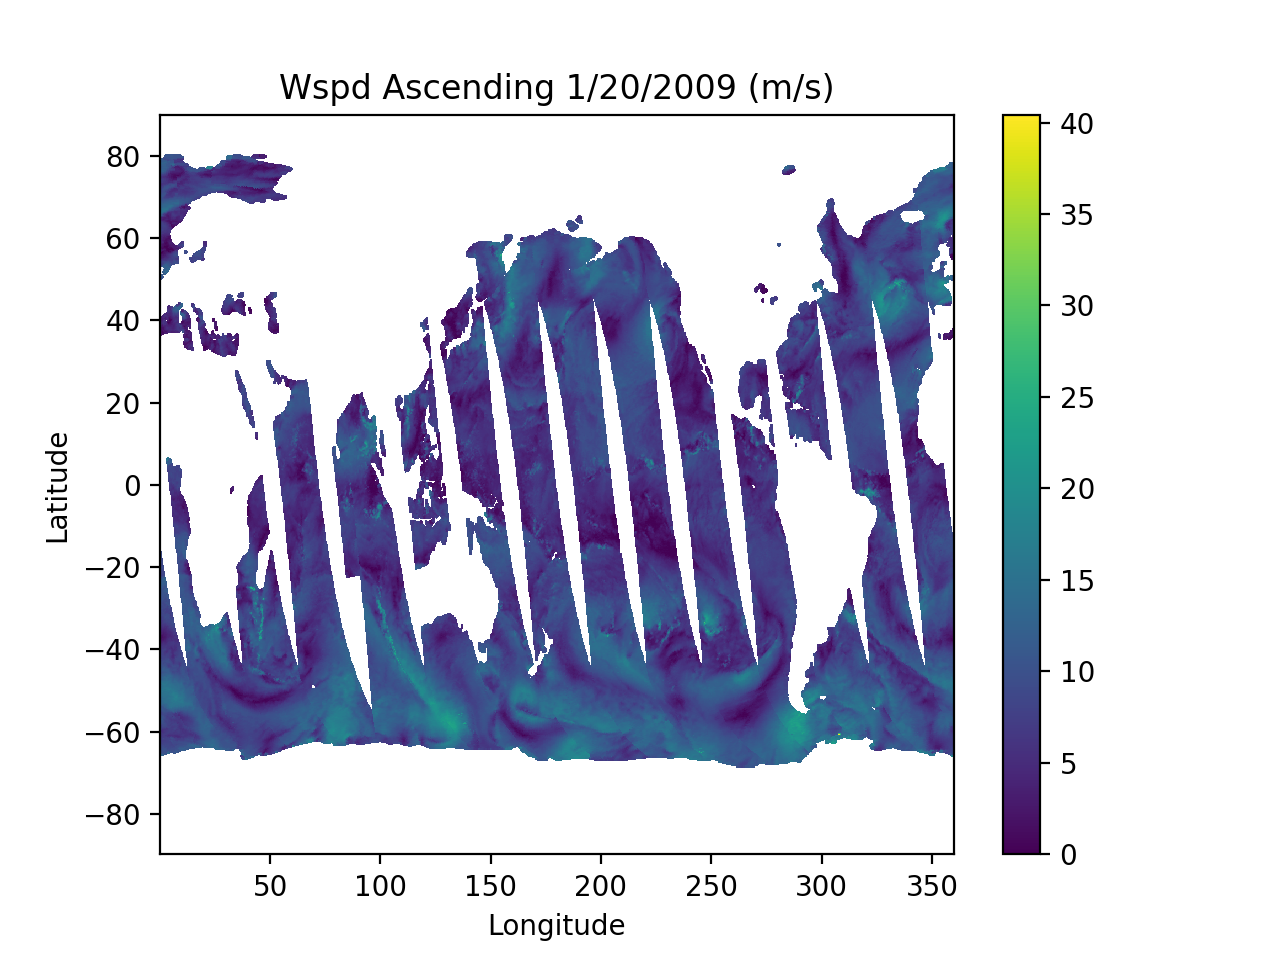

Text(0, 0.5, 'Latitude')

In [31]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonA,latA,wspdA)
fig.colorbar(pc,ax=ax)
ax.set_title('Wspd Ascending 1/20/2009 (m/s)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

<IPython.core.display.Javascript object>


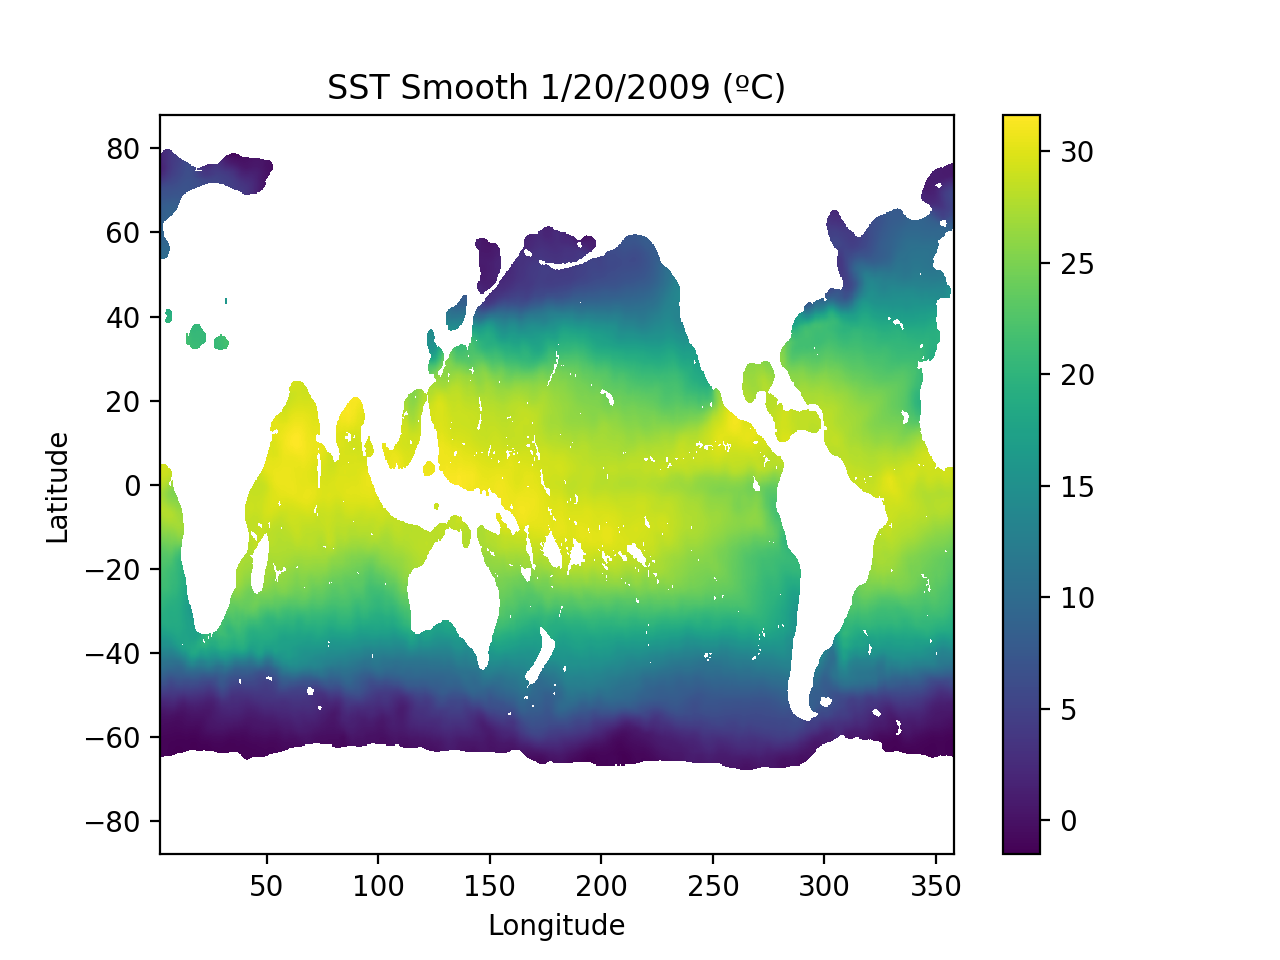

Text(0, 0.5, 'Latitude')

In [32]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,sstsmooth)
fig.colorbar(pc,ax=ax)
ax.set_title('SST Smooth 1/20/2009 (ºC)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

<IPython.core.display.Javascript object>


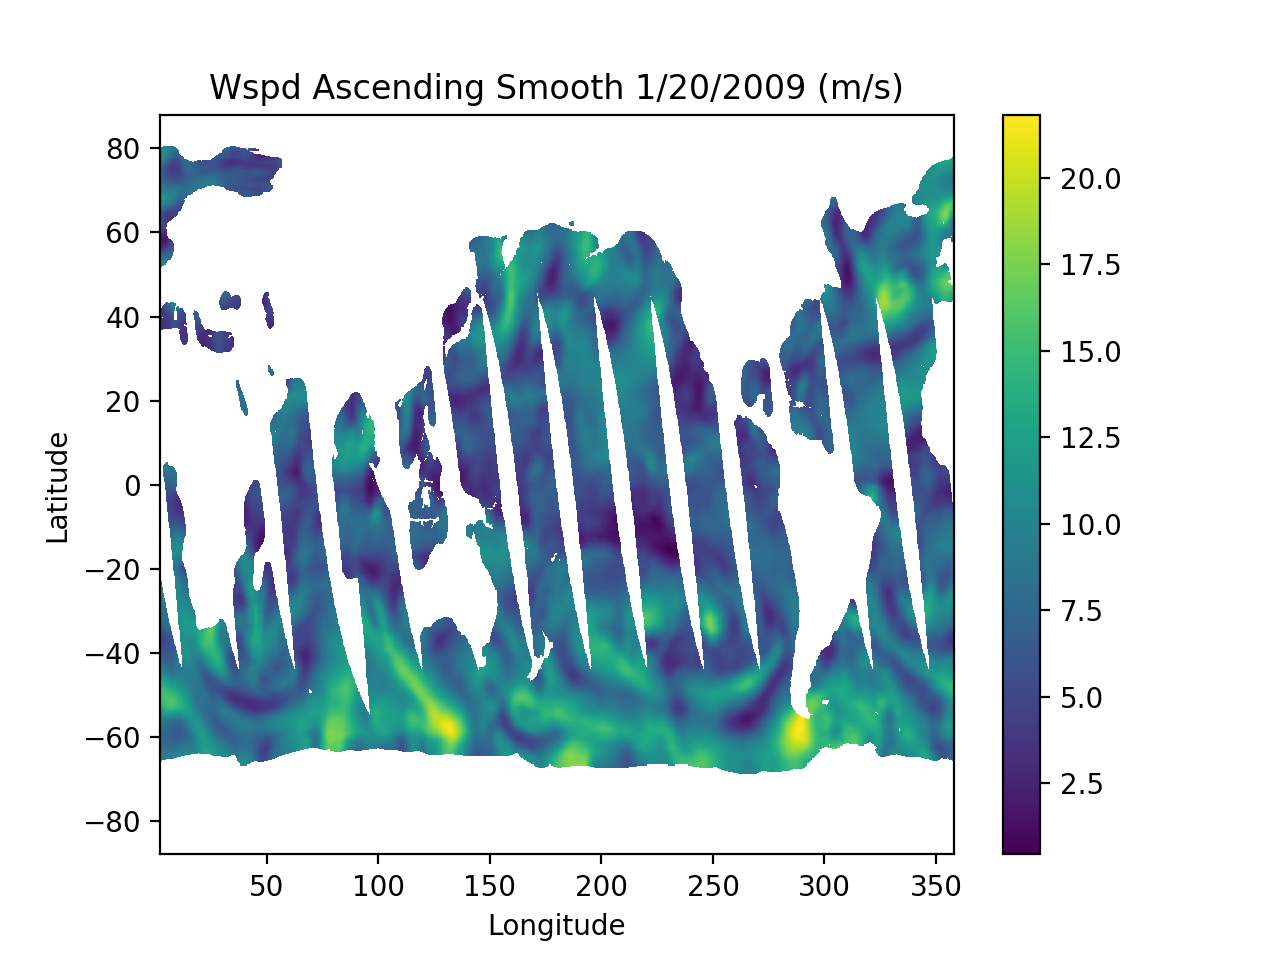

Text(0, 0.5, 'Latitude')

In [33]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,wspdAsmooth)
fig.colorbar(pc,ax=ax)
ax.set_title('Wspd Ascending Smooth 1/20/2009 (m/s)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

<IPython.core.display.Javascript object>


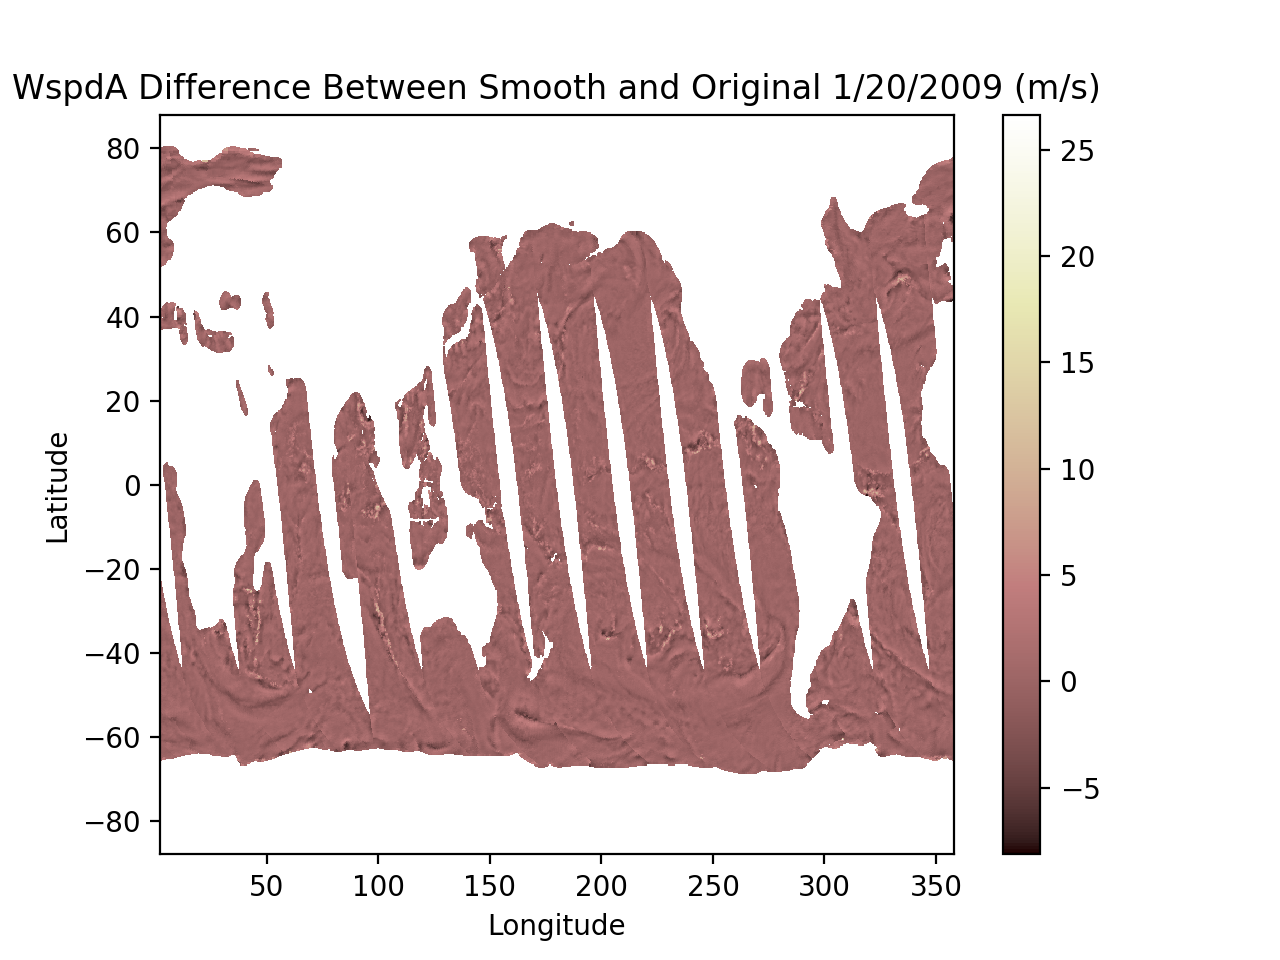

Text(0, 0.5, 'Latitude')

In [34]:
wspdAdiff = wspdAshort - wspdAsmooth

fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,wspdAdiff,cmap=plt.cm.get_cmap('pink'))#,vmin=-17, vmax=17)


#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5, cmap=custom_div_cmap(mincol='#1b7837', maxcol='#762a83'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('Blues'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu_r'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('seismic'),vmin=-40, vmax=40)
#ax.contour(lonAsmooth,latAsmooth,wspdAdiff,[0],colors='white', linewidths=.5)
fig.colorbar(pc,ax=ax)
ax.set_title('WspdA Difference Between Smooth and Original 1/20/2009 (m/s)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

<IPython.core.display.Javascript object>


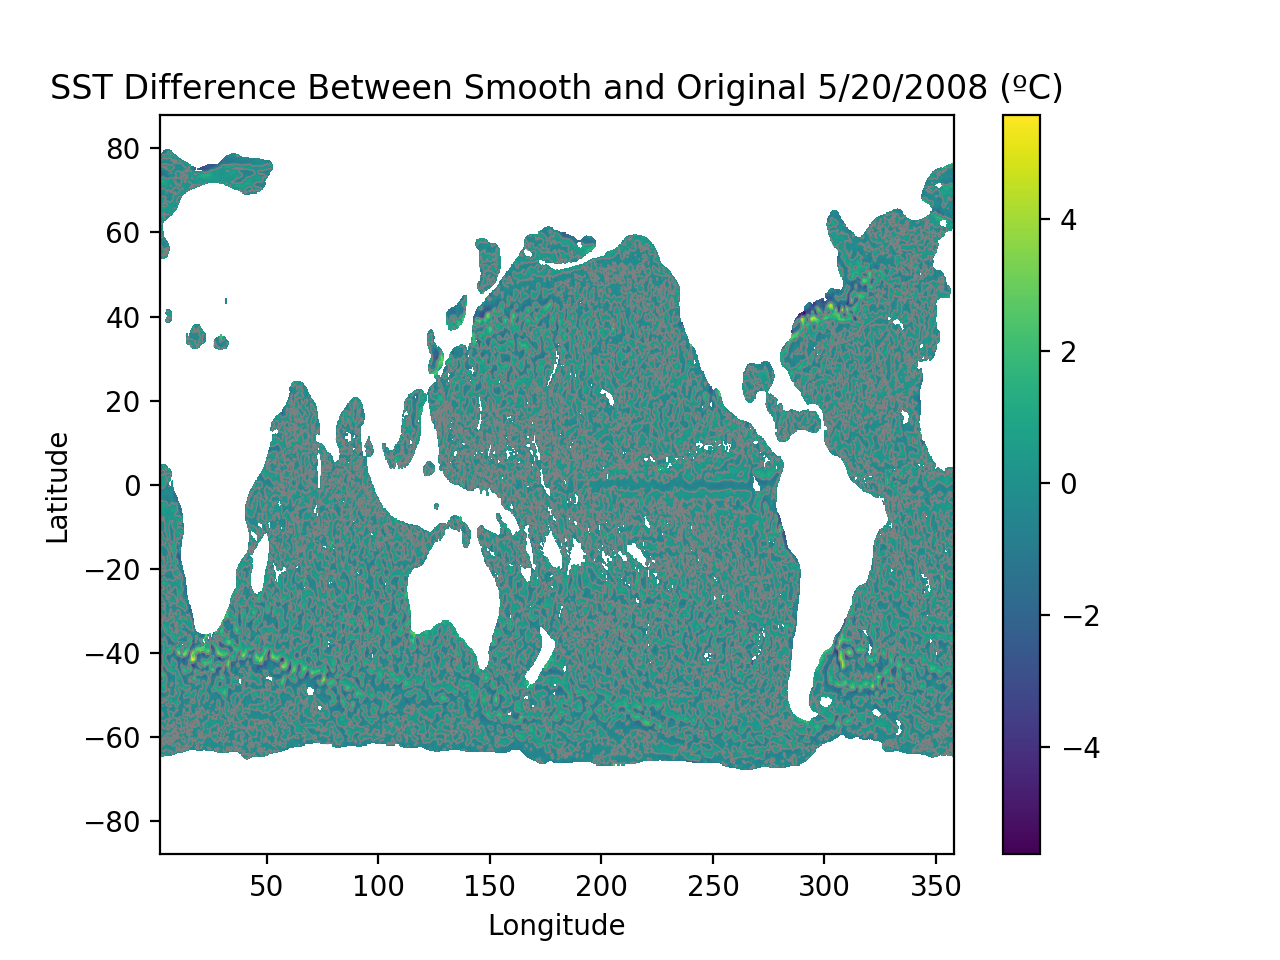

Text(0, 0.5, 'Latitude')

In [35]:
sstdiff = sstshort - sstsmooth

fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,sstdiff)
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,sstdiff,cmap=plt.cm.get_cmap('RdYlBu_r'),vmin=-8, vmax=8)
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,sstdiff,cmap=plt.cm.get_cmap('RdBu_r'),vmin=-10, vmax=10)

ax.contour(lonAsmooth,latAsmooth,sstdiff,[0],colors='gray', linewidths=.5)
fig.colorbar(pc,ax=ax)
ax.set_title('SST Difference Between Smooth and Original 5/20/2008 (ºC)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


## Smoothing Across Region 1

In [21]:
f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/AgulhasN17A.nc','r')
grp = f.groups['Regional_data']

print(f)
print(grp)
lon = grp.variables['Longitude'][:]
lat = grp.variables['Latitude'][:]
time = grp.variables['Time'][:]
wspdA = grp.variables['Wind Speed Ascending'][:,:,:]
sst = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
Q = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1 = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q2 = grp.variables['Linear Term, Function of T  (Q2)'][:,:,:]
Q3=grp.variables['Linear Term, Function of U (Q3)'][:,:,:]
Q4=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5=grp.variables['Covariability of SST and U (Q5)'][:,:,:]

f.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Region = Agulhas; N = 17; Time = 2003/01/01 - 2008/12/31; Wind Ascending
    dimensions(sizes): 
    variables(dimensions): 
    groups: Regional_data
<class 'netCDF4._netCDF4.Group'>
group /Regional_data:
    dimensions(sizes): lon(301), lat(77), time(2192)
    variables(dimensions): float32 Longitude(lon), float32 Latitude(lat), int32 Time(time), float32 Wind Speed Ascending(time,lat,lon), float32 Wind Speed Ascending Smooth(time,lat,lon), float32 Sea Surface Temperature(time,lat,lon), float32 Sea Surface Temperature Smooth(time,lat,lon), float32 Latent Heat Flux Observational (Q)(time,lat,lon), float32 Latent Heat Flux Large Scale (Q1)(time,lat,lon), float32 Linear Term, Function of T  (Q2)(time,lat,lon), float32 Linear Term, Function of U (Q3)(time,lat,lon), float32 Clausius Clapeyron (Q4)(time,lat,lon), float32 Covariability of SST and U (Q5)(time,lat,lon), float32 Standard Devia

<IPython.core.display.Javascript object>


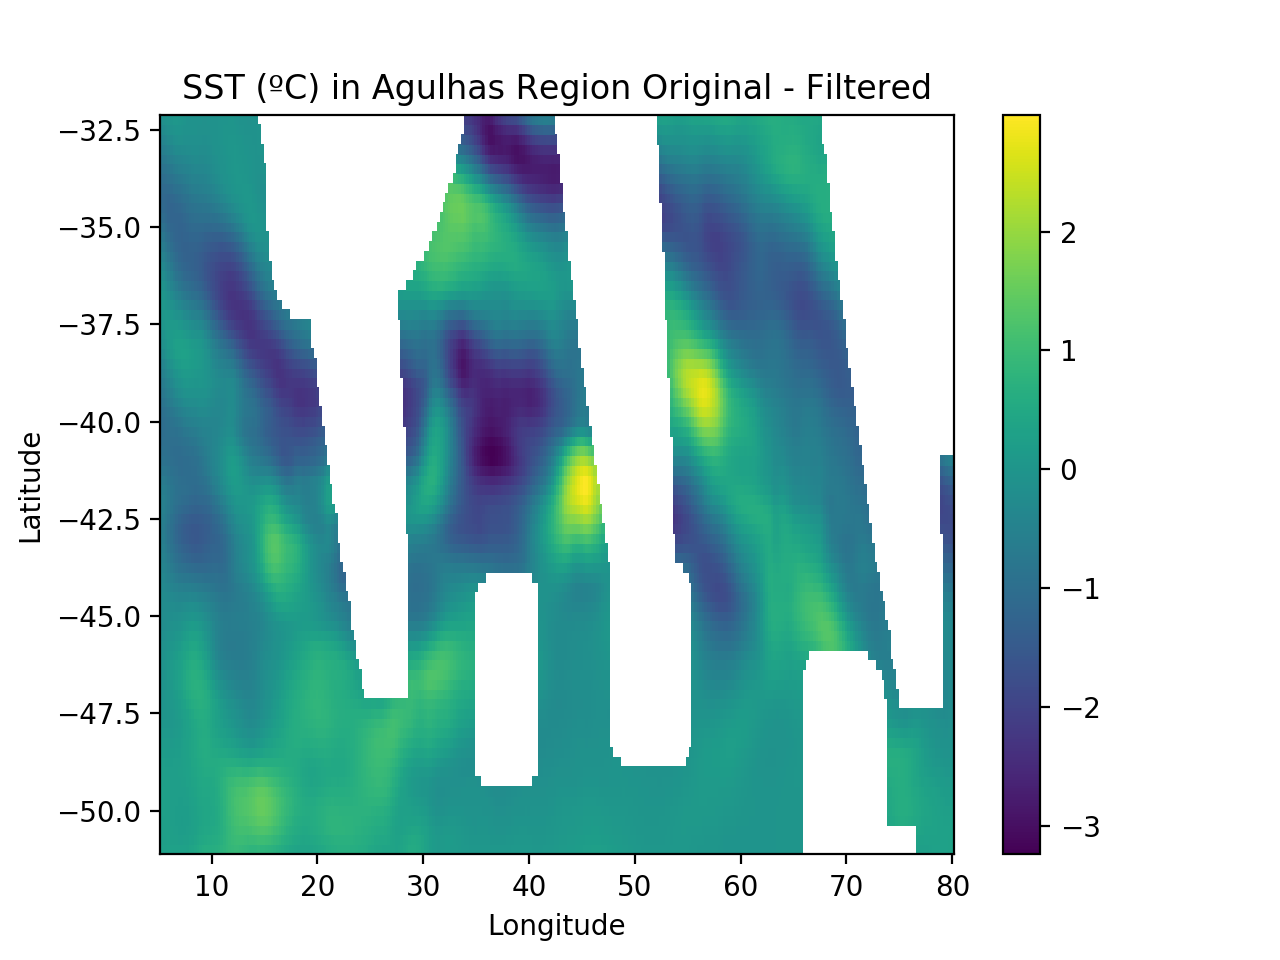

Text(0.5, 1.0, 'SST (ºC) in Agulhas Region Original - Filtered')

In [27]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lon,lat,Q5[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('SST (ºC) in Agulhas Region Original - Filtered')

In [36]:
#Region South of Africa is eddy rich (ER): lat (50,-35), lon (10,40)

#latER = [-51,-31]
#lonER = [0,80]
latERpt = [-51,-31]
lonERpt = [6,53]

latER, lonER, sstER = data_slice(latERpt,lonERpt,sstshort,latAsmooth,lonAsmooth)
_, _, sstsmoothER = data_slice(latERpt,lonERpt,sstsmooth,latAsmooth,lonAsmooth)
_, _, wspdAER = data_slice(latERpt,lonERpt,wspdAshort,latAsmooth,lonAsmooth)
_, _, wspdAsmoothER = data_slice(latERpt,lonERpt,wspdAsmooth,latAsmooth,lonAsmooth)


<IPython.core.display.Javascript object>


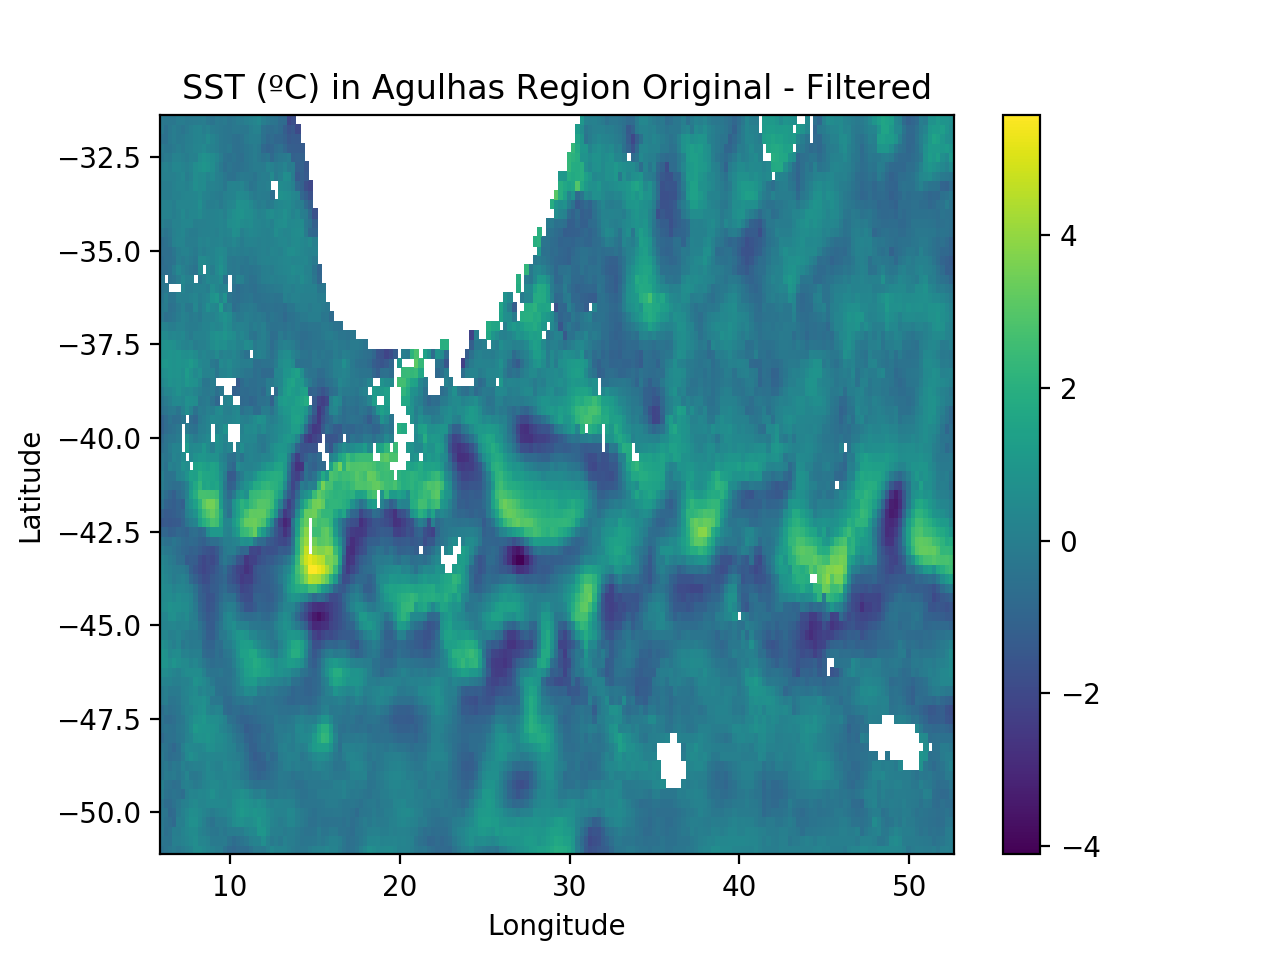

Text(0.5, 1.0, 'SST (ºC) in Agulhas Region Original - Filtered')

In [37]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonER,latER,sstER - sstsmoothER)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('SST (ºC) in Agulhas Region Original - Filtered')

12.625
(720,)
(301,)


<IPython.core.display.Javascript object>


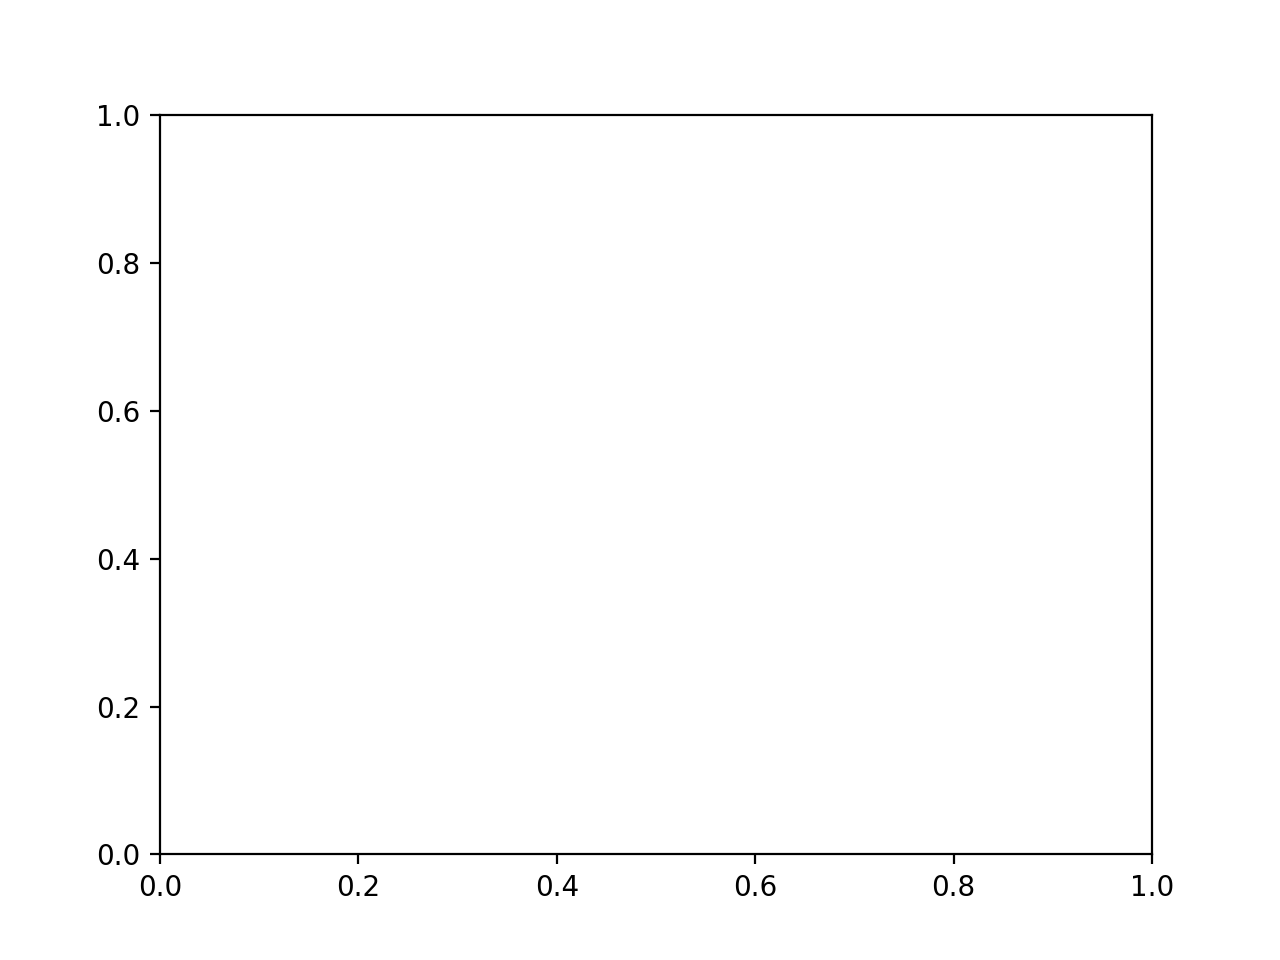

ValueError: x and y must have same first dimension, but have shapes (77,) and (720,)

In [40]:
sstER_NS = sst[:,50]
sstsmoothER_NS = sstsm[:,50]
print(lon[50])

print(sstER_NS.shape)
print(lon.shape)

fig, axs = plt.subplots()
ax = axs
ax.plot(lat,sstER_NS,'g',label='SST')
ax.plot(lat,sstsmoothER_NS,'y',label='SST Smooth')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('SST of Agulhas Confluence Region Slice N-S at 22.375ºE')
ax.set_ylabel('SST (ºC)')
ax.set_xlabel('Latitude')



13.375


<IPython.core.display.Javascript object>


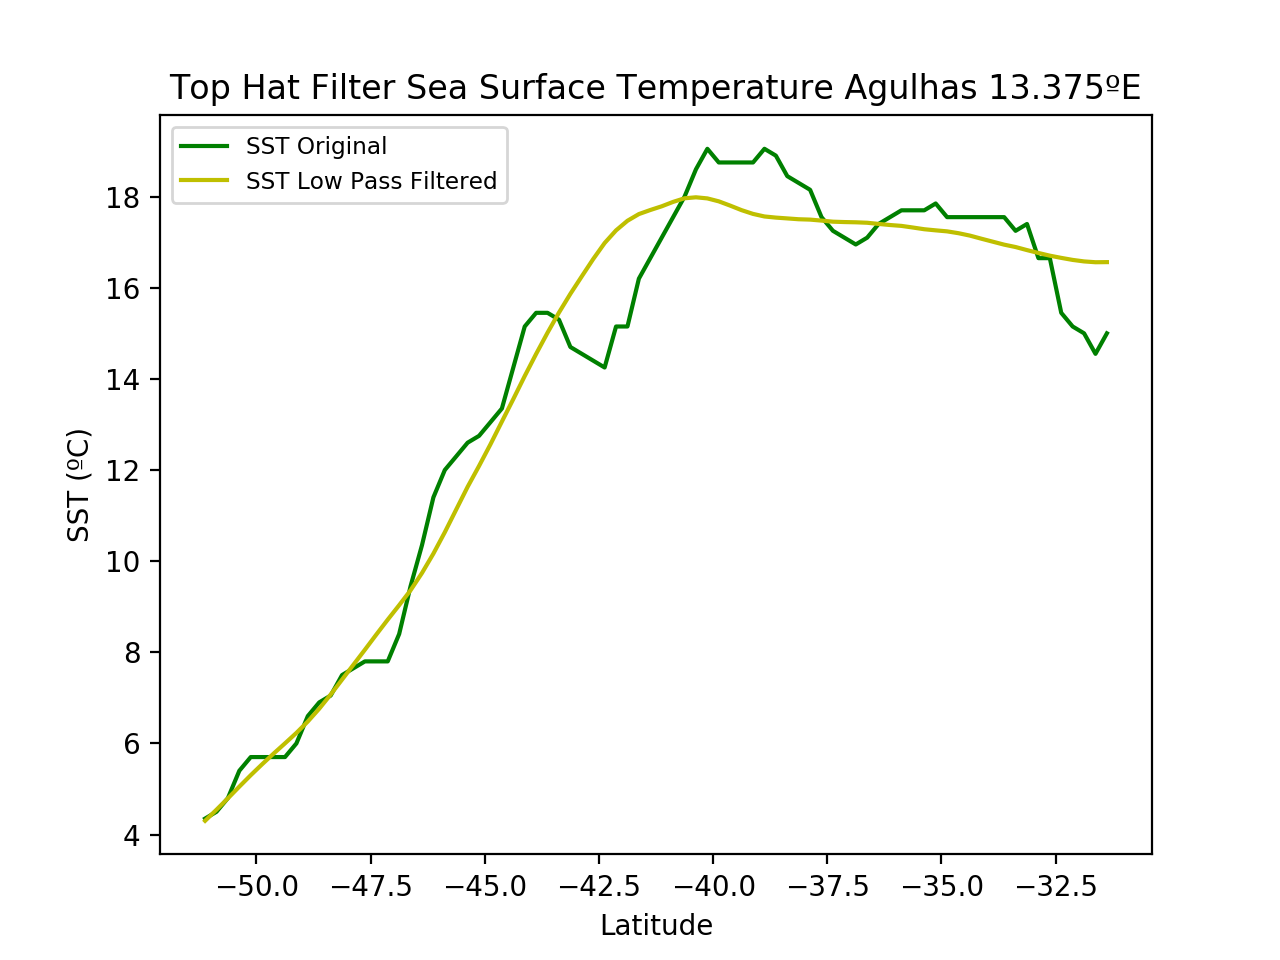

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


Text(0.5, 0, 'Latitude')

In [45]:
sstER_NS = sstER[:,30]
sstsmoothER_NS = sstsmoothER[:,30]
print(lonER[30])

fig, axs = plt.subplots()
ax = axs
ax.plot(latER,sstER_NS,'g',label='SST Original')
ax.plot(latER,sstsmoothER_NS,'y',label='SST Low Pass Filtered')
ax.legend(loc='bottom right', fontsize='small', ncol=1)
ax.set_title('Top Hat Filter Sea Surface Temperature Agulhas 13.375ºE')
ax.set_ylabel('SST (ºC)')
ax.set_xlabel('Latitude')


In [19]:
sstER_EW = sstER[10,:]
sstsmoothER_EW = sstsmoothER[10,:]

print(latER[10])

fig, axs = plt.subplots()
ax = axs
ax.plot(lonER,sstER_EW,'g',label='SST')
ax.plot(lonER,sstsmoothER_EW,'y',label='SST Smooth')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('SST of Agulhas Confluence Region Slice E-W at -47.625ºS')
ax.set_ylabel('SST (ºC)')
ax.set_xlabel('Longitude')

NameError: name 'sstER' is not defined

## Smoothing Across Region 2

In [17]:
#Gulf Stream (GS) has steep gradients: lat (33,45), lon (290,320)

latGSpt = [32,52]
lonGSpt = [285,328]

latGS, lonGS, sstGS = data_slice(latGSpt,lonGSpt,sstshort,latAsmooth,lonAsmooth)
_, _, sstsmoothGS = data_slice(latGSpt,lonGSpt,sstsmooth,latAsmooth,lonAsmooth)
_, _, wspdAGS = data_slice(latGSpt,lonGSpt,wspdAshort,latAsmooth,lonAsmooth)
_, _, wspdAsmoothGS = data_slice(latGSpt,lonGSpt,wspdAsmooth,latAsmooth,lonAsmooth)

NameError: name 'sstshort' is not defined

In [ ]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonGS,latGS,sstGS-sstsmoothGS)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('SST (ºC) in Gulf Stream Original - Filtered')

In [ ]:
sstGS_NS = sstGS[:,30]
sstsmoothGS_NS = sstsmoothGS[:,30]
print(lonGS[30])

fig, axs = plt.subplots()
ax = axs
ax.plot(latGS,sstGS_NS,'g',label='SST')
ax.plot(latGS,sstsmoothGS_NS,'y',label='SST Smooth')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('SST of Gulf Stream Slice N-S')
ax.set_ylabel('SST (ºC)')
ax.set_xlabel('Latitude')

In [ ]:
sstGS_EW = sstGS[20,:]
sstsmoothGS_EW = sstsmoothGS[20,:]
print(latGS[20])

fig, axs = plt.subplots()
ax = axs
ax.plot(lonGS,sstGS_EW,'g',label='SST')
ax.plot(lonGS,sstsmoothGS_EW,'y',label='SST Smooth')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('SST of Gulf Stream Slice N-S')
ax.set_ylabel('SST (ºC)')
ax.set_xlabel('Longitude')

## Global LH Smoothing

In [ ]:
QL_globe = calculate_QL(sst,wspdA)
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonQ,latQ,QL_globe, cmap=custom_div_cmap(numcolors=20, midcol='#1b7837',mincol='#eaffbf', maxcol='#762a83'))#,vmax=400)
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat (W/m^2)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


print("Global Average of Latent Heat: ", np.nanmean(QL_globe),"W/m^2")

In [ ]:
QL_globe2 = calculate_QL(sstsmooth,wspdAshort)
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,QL_globe2, cmap=custom_div_cmap(numcolors=20, mincol='#003a8e', maxcol='#fafc97', midcol='#ffaef7'))
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat with Smooth SST (W/m^2)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print("Global Average of Latent Heat w/ Smooth SST: ",\
      np.nanmean(QL_globe2),"W/m^2")

In [ ]:
QL_globe3 = calculate_QL(sstshort,wspdAsmooth)
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,QL_globe3)
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat with Smooth WspdA (W/m^2)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print("Global Average of Latent Heat w/ WspdA Smooth: ", \
      np.nanmean(QL_globe3),"W/m^2")

In [ ]:
QL_globe4 = calculate_QL(sstsmooth,wspdAsmooth)
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,QL_globe4)
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat with Smooth WspdA and SST')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print("Global Average of Latent Heat w/ both smooth: ", \
      np.nanmean(QL_globe4),"W/m^2")

## Smoothing Impacts of LH in Region 1

In [ ]:
#orginal data
QLER = calculate_QL(sstER,wspdAER)
print("Latent Heat in Eddy Rich Region Both Original:",np.nanmean(QLER))

#sst smooth, wspd original
QLER_sstsm = calculate_QL(sstsmoothER,wspdAER)

#sst original, wspd smooth
QLER_wspdAsm = calculate_QL(sstER,wspdAsmoothER)

#sst smooth, wspd smooth
QLER_sstwspdAsm = calculate_QL(sstsmoothER,wspdAsmoothER)



#clean_data ensures that both QL we compare have the same # of data points
print("Latent Heat in Eddy Rich Region")
A, B = clean_data(QLER,QLER_sstsm)
print("Original vs. SST smoothed and WspdA Original (W/m^2):", \
    np.nanmean(A),"vs", np.nanmean(B))

A, B = clean_data(QLER,QLER_wspdAsm)
print("Original vs. WspdA smoothed and SST Original (W/m^2):", \
      np.nanmean(A),"vs", np.nanmean(B))

A, B = clean_data(QLER,QLER_sstwspdAsm)
print("Original vs. SST and WspdA smoothed (W/m^2):", \
      np.nanmean(A),"vs", np.nanmean(B))

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.5,wspace=.5)


ax = axs[0,0]
pc = ax.pcolormesh(lonER,latER,QLER)
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[0,1]
pc = ax.pcolormesh(lonER,latER,QLER_sstsm)
fig.colorbar(pc,ax=ax)
ax.set_title('LH, Smooth SST, Original U')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,0]
pc = ax.pcolormesh(lonER,latER,QLER_wspdAsm)
fig.colorbar(pc,ax=ax)
ax.set_title('LH, Smooth U, Original SST')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,1]
pc = ax.pcolormesh(lonER,latER,QLER_sstwspdAsm)
fig.colorbar(pc,ax=ax)
ax.set_title('LH, Smooth U, Smooth SST')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)



## Smoothing Impacts of LH in Region 2

In [ ]:
#orginal data
QLGS = calculate_QL(sstGS,wspdAGS)

#sst smooth, wspd original
QLGS_sstsm = calculate_QL(sstsmoothGS,wspdAGS)

#sst original, wspd smooth
QLGS_wspdAsm = calculate_QL(sstGS,wspdAsmoothGS)

#sst smooth, wspd smooth
QLGS_sstwspdAsm = calculate_QL(sstsmoothGS,wspdAsmoothGS)


print("Latent Heat in Gulf Stream: ", \
      np.nanmean(QLGS),"W/m^2")
print("Latent Heat in Gulf Stream with SST smooth & U original: ", \
      np.nanmean(QLGS_sstsm),"W/m^2")
print("Latent Heat in Gulf Stream with U smooth & SST original: ", \
      np.nanmean(QLGS_wspdAsm),"W/m^2")
print("Latent Heat in Gulf Stream with SST smooth & U smooth: ", \
      np.nanmean(QLGS_sstwspdAsm),"W/m^2")



#clean_data ensures that both QL we compare have the same # of data points
print("Latent Heat in Gulf Stream")

A, B = clean_data(QLGS,QLGS_sstsm)
print("Original vs. SST smoothed and WspdA Original (W/m^2):", \
    np.nanmean(A),"vs", np.nanmean(B))

A, B = clean_data(QLGS,QLGS_wspdAsm)
print("Original vs. WspdA smoothed and SST Original (W/m^2):", \
      np.nanmean(A),"vs", np.nanmean(B))

A, B = clean_data(QLGS,QLGS_sstwspdAsm)
print("Original vs. SST and WspdA smoothed (W/m^2):", \
      np.nanmean(A),"vs", np.nanmean(B))


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.6,wspace=.5)


ax = axs[0,0]
pc = ax.pcolormesh(lonGS,latGS,QLGS)
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[0,1]
pc = ax.pcolormesh(lonGS,latGS,QLGS_sstsm)
fig.colorbar(pc,ax=ax)
ax.set_title('LH, Smooth SST, Original U')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,0]
pc = ax.pcolormesh(lonGS,latGS,QLGS_wspdAsm)
fig.colorbar(pc,ax=ax)
ax.set_title('LH, Smooth U, Original SST')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,1]
pc = ax.pcolormesh(lonGS,latGS,QLGS_sstwspdAsm)
fig.colorbar(pc,ax=ax)
ax.set_title('LH, Smooth U, Smooth SST')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

## Smoothing with Gaussian

In [ ]:
def smoothg(data, data2, N=17):
    '''
    Description:
    
    Paramaters: "data" will be smoothed, "data2" will NOT be smoothed but 
        it will be shortened to the same size as "data." "N" is the width
        and length of the squares over which "data" is smoothed
    '''
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize    
    W = data.shape[0]
    L = data.shape[1]
    datasum = np.zeros((W-N+1,L-N+1)) #row, column
    counts = np.zeros((W-N+1,L-N+1))    
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(data.shape[0])
    indx_col = np.arange(data.shape[1])
    
    
    for i in range(N):
    
        delrow = np.delete(indx_row,slice(ai,W-af))
        data_delrow = np.delete(data,delrow,0)
    
        for j in range(N):       
            
            #delete excess rows and columns
            delcol = np.delete(indx_col,slice(bi,L-bf))
            data_delrowcol = np.delete(data_delrow,delcol,1)   
            
            #count number of good values
            goodind = np.where(np.isnan(data_delrowcol) == False)
            counts[goodind] = counts[goodind] + 1
            
            #change NaN to zero then add
            data_delrowcol[np.isnan(data_delrowcol) == True] = 0
            datasum = datasum + data_delrowcol     

            bi = bi-1
            bf = bf+1
        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    datasmooth = datasum/counts
    datasmooth[np.where(counts < (N**2)/2)] = None
    
    #delete points that were NaN in original data    
    a = int((N-1)/2)
    datashort = data[a:W-a, a:L-a]
    datasmooth[np.where(np.isnan(datashort) == True)] = None
    
    #makes data2 the same size as data
    data2short = data2[a:W-a, a:L-a]    
    

    
    return datasmooth, data2short


<IPython.core.display.Javascript object>


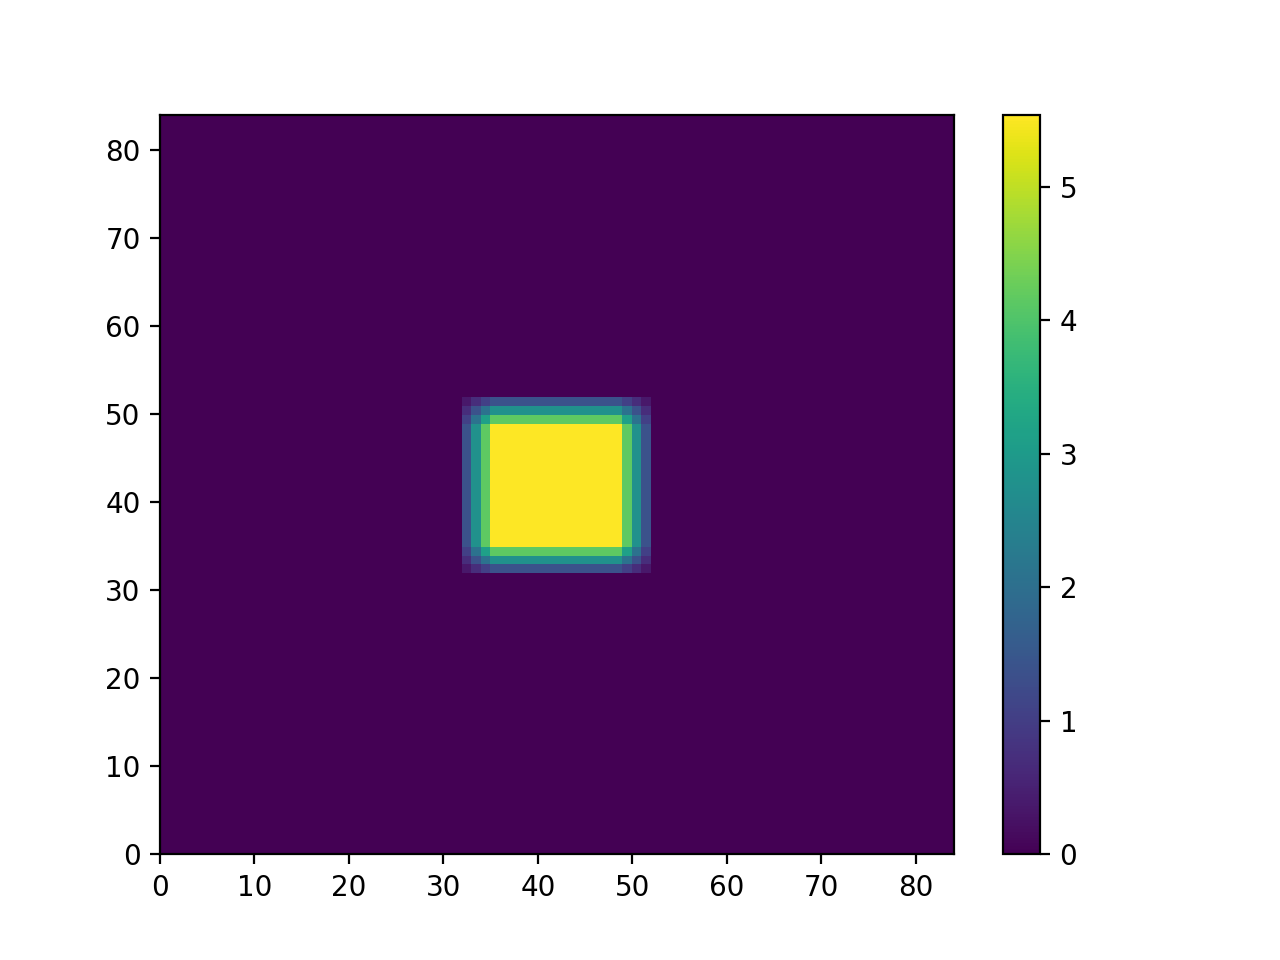

In [15]:
#test smooth function

#create imaginary data; size 100 x 100 w/ values of 100 on top half and 0 on bottom half
fakedata1 = np.zeros((100,100))
fakedata2 = np.zeros((100,100))
fakedata3 = np.zeros((100,100))
fakedata1[50:100,:] = 100
fakedata2[:,50:100] = 100
fakedata3[48:52,48:52] = 100
fakesmooth1,_ = smooth(fakedata1,fakedata1)
fakesmooth2,_ = smooth(fakedata2,fakedata2)
fakesmooth3,_ = smooth(fakedata3,fakedata3)

fig, ax = plt.subplots()
pc = ax.pcolormesh(fakesmooth3)
fig.colorbar(pc,ax=ax)


In [16]:
sstsmooth, wspdAshort = smoothg(sst,wspdA,N=17)
wspdAsmooth, sstshort = smoothg(wspdA,sst,N=17)

a = int((len(latA) - sstsmooth.shape[0])/2)
latAsmooth = latA[a:len(latA)-a]
lonAsmooth = lonA[a:len(lonA)-a]

NameError: name 'smoothg' is not defined